Saving Milano_timeseries.csv to Milano_timeseries (1).csv


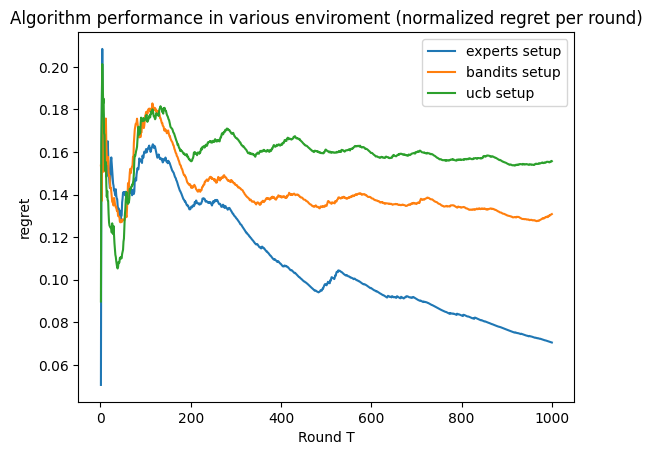

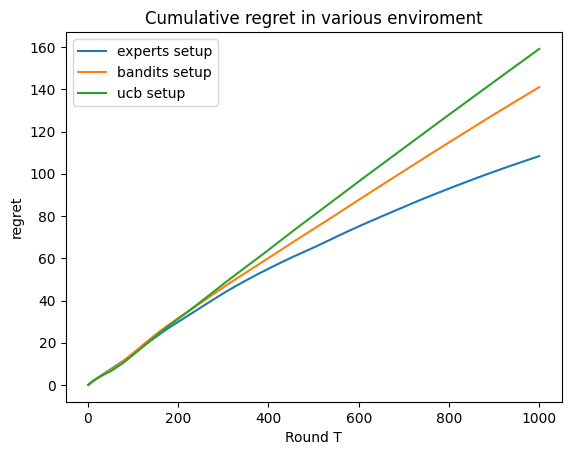

In [22]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

from google.colab import files
 
 
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['Milano_timeseries.csv']))


#df.columns[0]      label of first column
#df[df.columns[0]]  first column



T = 1000
servers = len(df.index)                   # the number of rows
eta = np.sqrt(np.log(servers) /T)
############### FOR EXPERTS         ##################

regret_exp = np.zeros((T,))               #regret for round t
cum_regret_exp = np.zeros((T,))           #cumulative regret for round t
min_score = np.zeros((T,))                #cumulative min_load of servers for round t
alg_score = np.zeros((T,))                #cumulative load for round t for algorithm  
w = np.ones((servers,))                   #weights of the servers at time t initially all have 1
p =  np.zeros((servers,))                 #probability for choosing each server at round t
loss = np.zeros((servers,))               #loss of each server at time t -> [0,1] i.e. the difference in loads
min_ld = np.zeros((T,))                   #cumulative min_load of servers for round t
# alg_ld = np.zeros((T,))                 #load chosen for round t from algorithm

############### FOR BANDITS         ##################

eps = 1/(T * servers)                     #exploration probability
regret_band =  np.zeros((T,))             #regret for round t
cum_regret_band = np.zeros((T,))          #cumulative regret for round t
alg_score_band = np.zeros((T,))           #cumulative load for round t for algorithm  
w_band = np.ones((servers,))              #weights of the servers at time t initially all have 1
p_band =  np.zeros((servers,))            #probability for choosing each server at round t
loss_band = np.zeros((servers,))          #loss of each server at time t -> [0,1] i.e. the difference in loads
# alg_ld_band = np.zeros((T,))            #load chosen for round t from algorithm

############### FOR UCB         ##################
#loads have values in [0,1] 
#for every server we calculate reward = 1-load as the reward of the server. Hence we will try to maximize the reward
#so as to fit in the concept of the algorithm
regret_ucb =  np.zeros((T,))              #regret for round t
cum_regret_ucb = np.zeros((T,))           #cumulative regret for round t
alg_score_ucb = np.zeros((T,))            #cumulative load for round t for algorithm  
times = np.zeros((servers,))              #num of times that a server is chosen
est_rewards = np.zeros((servers,))        #estimated rewards of the servers at time t
ucb = np.zeros((servers,))                #upper confidence bound for each server at any given time
server_score = np.zeros((servers,))       #total score of each server at time t
# alg_ld_ucb = np.zeros((T,))             #load chosen for round t from algorithm

for t in range(T):
  #find the best server for every timeslot
  loads = df[df.columns[t]].tolist()      #loads of servers for timeslot t
  min_load = np.amin(loads)               #least load
  best_server = np.argmin(loads)          #server with least load
  s = np.sum(w)                           #sum of weights of all servers at time t
  for ser in range(servers):
    p[ser] = w[ser] / s
  #now let's choose a server
  load_alg = rnd.choices(loads, weights=p, k=1)
  #now set new weights, losses
  for ser in range(servers):
    loss[ser] = loads[ser] - min_load     
    reduction = pow(1-eta, loss[ser])
    w[ser] = w[ser]*reduction

  ###BANDITS ENVIROMENT##########

  s_band = np.sum(w_band)                 #sum of weights of all servers at time t
  for ser in range(servers):
    p_band[ser] = w_band[ser] / s_band
  #now let's choose a server
  load_alg_band = rnd.choices(loads, weights=p_band, k=1)
  #now set new weights, losses
  #only the server that was chosen changes its weight
  choice = loads.index(load_alg_band[0])   #index of server that algo chose
  #loss_band[choice] = loads[choice] - min_load    #loss incurred from the chosen server
  loss_band[choice] = load_alg_band[0] - min_load  #loss incurred from the chosen server
  qi = ((1-eps) * p_band[choice]) + (eps/servers) 
  l_hat = loss_band[choice] / qi
  reduction = pow(1-eta, l_hat)
  w_band[choice] = w_band[choice]*reduction

  #UCB ALGORITHM
  
  if t == 0:                              #in 1st round we choose a server randomly
    load_alg_ucb = rnd.choice(loads)
    choice_ucb = loads.index(load_alg_ucb)    #index of server that algo chose
  else:
    choice_ucb = np.argmax(ucb)
    load_alg_ucb = loads[choice_ucb]
  times[choice_ucb] += 1
  server_score[choice_ucb] = server_score[choice_ucb] + (1- load_alg_ucb)
  est_rewards[choice_ucb] = server_score[choice_ucb]/times[choice_ucb]
  if t > 0:
    for ser in range(servers):            #update ucb of all servers
      if times[ser] == 0:
        ucb[ser] = est_rewards[ser] + float('inf')
      else:
        ucb[ser] = est_rewards[ser] + np.sqrt(np.log(t)/times[ser])
  if t > 0:
    min_score[t] = min_score[t-1] + min_load
    alg_score[t] = alg_score[t-1] + load_alg[0]
    alg_score_band[t] = alg_score_band[t-1] + load_alg_band[0]
    alg_score_ucb[t] = alg_score_ucb[t-1] + load_alg_ucb
  else:
    min_score[t] = min_load
    alg_score[t] = load_alg[0]            #it is a list with 1 item
    alg_score_band[t] = load_alg_band[0]
    alg_score_ucb[t] = load_alg_ucb
  regret_exp[t] = (alg_score[t] - min_score[t])/(t+1)           #regret per iteration at round t
  regret_band[t] = (alg_score_band[t] - min_score[t])/(t+1)     #regret per iteration at round t
  regret_ucb[t] = (alg_score_ucb[t] - min_score[t])/(t+1)       #regret per iteration at round t
  if t > 0 :
    cum_regret_exp[t] = cum_regret_exp[t-1] + regret_exp[t]
    cum_regret_band[t] = cum_regret_band[t-1] + regret_band[t]
    cum_regret_ucb[t] = cum_regret_ucb[t-1] + regret_ucb[t]
  else:
    cum_regret_exp[t] = regret_exp[t]
    cum_regret_band[t] = regret_band[t]
    cum_regret_ucb[t] = regret_ucb[t]
  # min_ld[t] = min_load
  # alg_ld[t] = load_alg[0]
  # alg_ld_band[t] = load_alg_band[0]
  # alg_ld_ucb[t] = load_alg_ucb


plt.title("Algorithm performance in various enviroment (normalized regret per round)") 
plt.xlabel("Round T") 
plt.ylabel("regret") 
plt.plot(np.arange(1,T+1),regret_exp)
plt.plot(np.arange(1,T+1),regret_band)
plt.plot(np.arange(1,T+1),regret_ucb) 
plt.legend(["experts setup", "bandits setup", "ucb setup"])   
plt.show()

plt.title("Cumulative regret in various enviroment") 
plt.xlabel("Round T") 
plt.ylabel("regret") 
plt.plot(np.arange(1,T+1),cum_regret_exp)
plt.plot(np.arange(1,T+1),cum_regret_band)
plt.plot(np.arange(1,T+1),cum_regret_ucb) 
plt.legend(["experts setup", "bandits setup", "ucb setup"])   
plt.show()

# plt.title("Hedge performance in experts enviroment") 
# plt.xlabel("Round T") 
# plt.ylabel("loads cum") 
# plt.plot(np.arange(1,T+1),min_score)
# plt.plot(np.arange(1,T+1),alg_score)
# plt.legend(["min score", "algo score"]) 
# plt.show()

# plt.title("Hedge performance in adversarial bandits enviroment") 
# plt.xlabel("Round T") 
# plt.ylabel("regret") 
# plt.plot(np.arange(1,T+1),regret_band) 
# plt.show()

# plt.title("Hedge performance in adversarial bandits enviroment") 
# plt.xlabel("Round T") 
# plt.ylabel("loads cum") 
# plt.plot(np.arange(1,T+1),min_score)
# plt.plot(np.arange(1,T+1),alg_score_band)
# plt.legend(["min score", "algo score"]) 
# plt.show()

# plt.title("UCB performance") 
# plt.xlabel("Round T") 
# plt.ylabel("regret") 
# plt.plot(np.arange(1,T+1),regret_ucb) 
# plt.show()

# plt.title("UCB performance") 
# plt.xlabel("Round T") 
# plt.ylabel("loads cum") 
# plt.plot(np.arange(1,T+1),min_score)
# plt.plot(np.arange(1,T+1),alg_score_ucb)
# plt.legend(["min score", "algo score"]) 
# plt.show()
